# Create low Poly images by randomly generating triangles on images an average over their pixels

This notebook improves the horrendous first attempt to create low poly images utilizing Dulaunay method on randomly generated coordinates. 
It is not meant to be performant as it is just a little project. 

First, lets take a look at the original image.

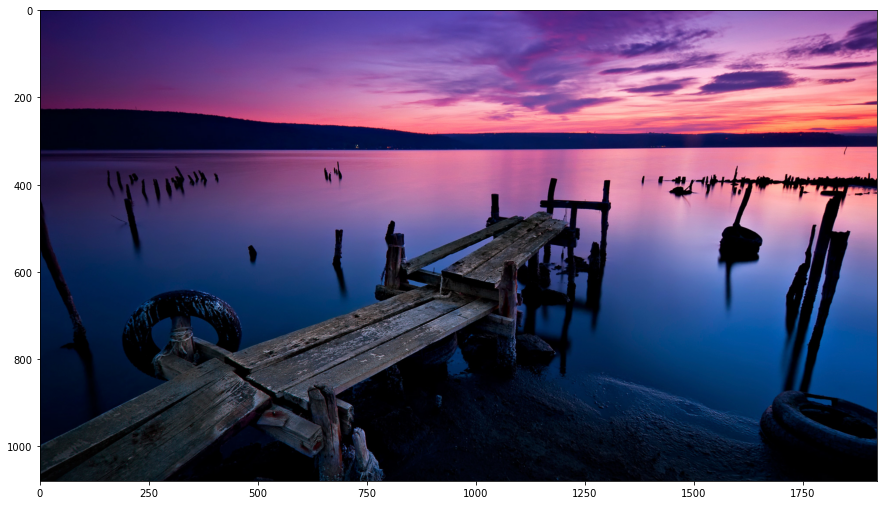

In [68]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

img_orig = plt.imread("test_image.jpg")
plt.imshow(img_orig); plt.show()

Now lets generate a simple grid over the image and display to see where our anchor points are.  
The points that are generated cover more than the image itself to accomondate for future modifications of the points. This is done using the badly named "over_edge_factor".

Image shape: (1080, 1920, 3)


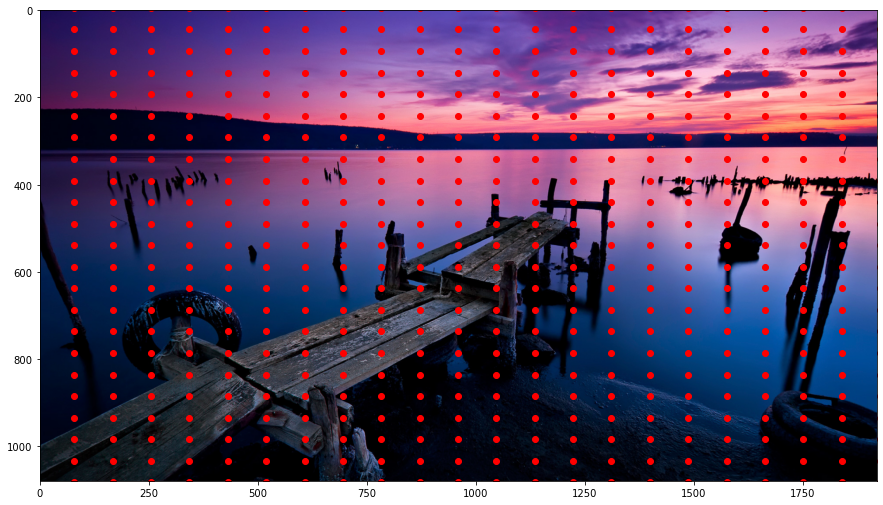

In [69]:
import numpy as np
import cv2

n_points_per_dim = 25
over_edge_factor = 0.05

height, width = img_orig.shape[:2]
print("Image shape:", img_orig.shape)
x = np.linspace(-width*over_edge_factor, width-1 + width*over_edge_factor, n_points_per_dim, dtype=int)
y = np.linspace(-height*over_edge_factor, height-1 + height*over_edge_factor, n_points_per_dim, dtype=int)
xx,yy = np.meshgrid(x,y)
xx,yy = xx.ravel(), yy.ravel()
coords = np.array([xx,yy]).T

img = img_orig.copy()
plt.imshow(img)
plt.plot(coords[:,0], coords[:,1], "ro")
plt.imshow(img); plt.show()

As this grid is quite boring and (probably) would not produce a nice image, we apply a little randomness to the coordinates. In this case we just use np.random.normal, but there are many other ways to do this. Keep in mind to apply this to xx and yy, as we would get a "structured randomness" otherwise.

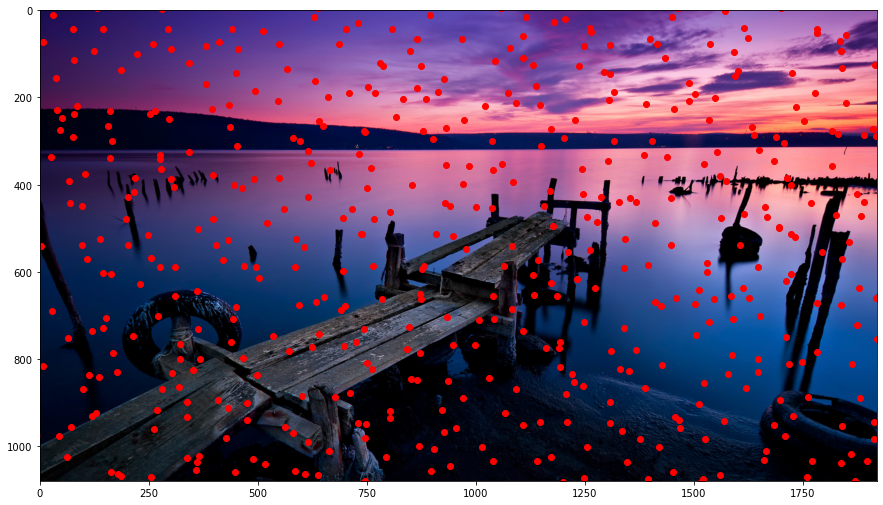

In [70]:
xx += np.random.normal(0,width//n_points_per_dim / 2, size=xx.shape).astype(int)
yy += np.random.normal(0,height//n_points_per_dim / 2, size=yy.shape).astype(int)
coords = np.array([xx,yy]).T

img = img_orig.copy()
plt.imshow(img)
plt.plot(coords[:,0], coords[:,1], "ro")
plt.imshow(img); plt.show()


Now comes the difficult part: Generate good triangles using the generated coordinates. "Difficult" as in someone had to implement it, we just import it from scipy....

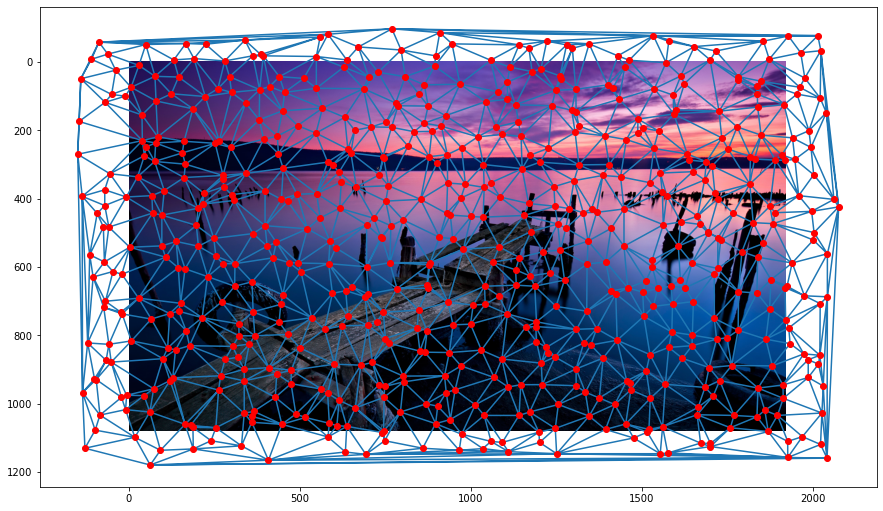

In [71]:
from scipy.spatial import Delaunay

tri = Delaunay(coords)
plt.imshow(img)
plt.triplot(coords[:,0], coords[:,1], tri.simplices)
plt.plot(coords[:,0], coords[:,1], 'ro')
plt.show()

While this looks quite fancy already, we now need to compute the contents of the triangles to generate. To do this, we first need to get all points (and their colors in the image) within a given triangle. As this is quite annoying to compute ourselfes, just use this answer from StackOverflow https://stackoverflow.com/a/45731214.  

In [72]:
from matplotlib.path import Path

def getPointsInPoly(tupVerts, width, height):
    x, y = np.meshgrid(np.arange(width), np.arange(height)) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 

    p = Path(tupVerts) # make a polygon
    grid = p.contains_points(points)
    mask = grid.reshape(height, width) # now you have a mask with points inside a polygon

    return mask


for triangle in tri.simplices[:5]:
    tri_coords = np.array([coords[i] for i in triangle], dtype=int)
    print(tri_coords)
    mask = getPointsInPoly(tri_coords, width, height)
    print(mask.shape, np.sum(mask))

[[2042 1159]
 [2043  687]
 [2076  424]]
(1080, 1920) 0
[[-110   -8]
 [-141   49]
 [ -88  -58]]
(1080, 1920) 0
[[-141   49]
 [-146  174]
 [-150  270]]
(1080, 1920) 0
[[ -70  118]
 [-146  174]
 [-141   49]]
(1080, 1920) 0
[[-115  564]
 [-121  822]
 [-137  393]]
(1080, 1920) 0


Now we need to get all the colors from the mask, simply by using average over the image coordinates and generate a new image.

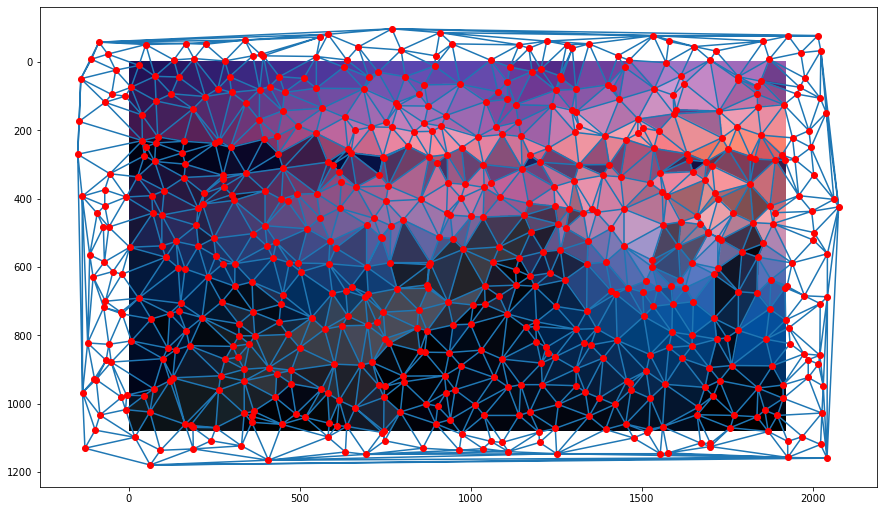

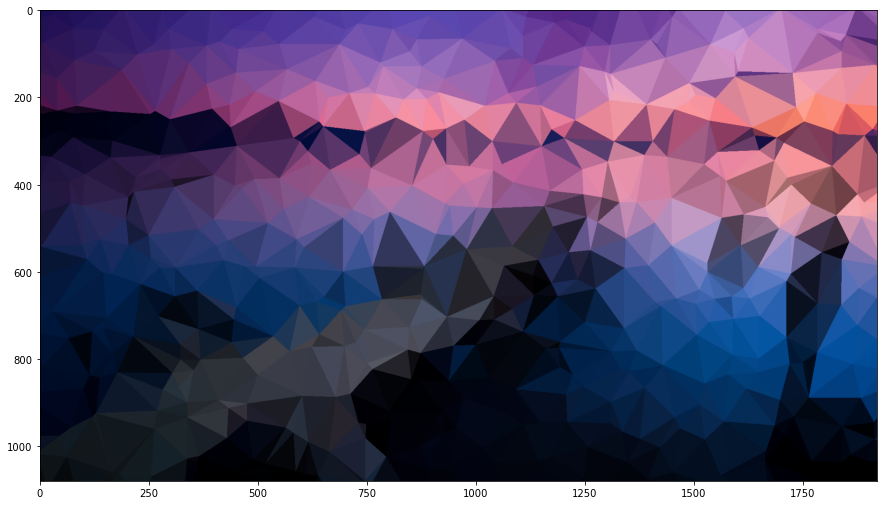

In [73]:
img = np.ones(shape=(img_orig.shape), dtype=int) + np.average(img_orig, axis=(0,1)).astype(int)

for triangle in tri.simplices:
    tri_coords = np.array([coords[i] for i in triangle], dtype=int)
    mask = getPointsInPoly(tri_coords, width, height)
    if(np.sum(mask)):
        img[mask] = np.average(img_orig[mask], axis=0)

plt.imshow(img)
plt.triplot(coords[:,0], coords[:,1], tri.simplices)
plt.plot(coords[:,0], coords[:,1], 'ro')
plt.show()

plt.imshow(img); plt.axis("off")
plt.show()

In [76]:
import cv2
cv2.imwrite("low_poly_res.jpg", img[:,:,::-1])

True